In [5]:
using Random, Distributions, RandomNumbers, Statistics
using ModelingToolkit, DifferentialEquations, Plots

In [63]:

function plot_quantile(t, y, q, color="black", label="95% CI", legend=:topright)

    up_q  = quantile.(eachrow(y), q/2)
    low_q = quantile.(eachrow(y), 1-q/2)

    p = plot(t, low_q, fillrange = up_q, fillalpha = 0.5, c = color, label = "95% CI", legend = :topright, linealpha=0)

    return p
end


plot_quantile (generic function with 4 methods)

In [64]:
function binomial_transition(x, τ, δτ=1)
    p = 1 .- exp.(-τ .* δt)
    return rand.(Binomial.(x, p))
end

function sir_stochastic(x, θ, t, δt=1)
    β, γ, N = θ

    s = x[1, :]
    i = x[2, :]
    r = x[3, :]

    λ = β .* i ./ N

    s2i = binomial_transition(s, λ, δt)
    i2r = binomial_transition(i, γ, δt)

    s .= s .- s2i
    i .= i .+ s2i .- i2r
    r .= r .+ i2r

    return transpose(cat(s, i, r, dims=2))
end

function g(x, θ, ρ=2/100)
    β, γ, N = θ
    i = x[2, :]
    return rand.(Binomial.(i, ρ))
end


g (generic function with 2 methods)

In [65]:
R0 = 2.0
γ  = 1/5
N  = 1e6
δt = 1.0

θ  = [R0*γ, γ, N, δt]

T = 25
n = 3
m = 700

i0 = 10/100
x0 = [N*(1-i0), N*i0, 0] * ones(Float64, 1, m);

x         = Array{Float64}(undef, T, n, m)
x[1,:,:] .= x0;


ysim       = Array{Float64}(undef, T, m)
ysim[1, :] = g(x0, θ)

for t in 1:T-1
    x[t+1,:,:]  = sir_stochastic(x[t,:,:], θ, t)
    ysim[t+1,:] = g(x[t+1,:,:], θ)
end


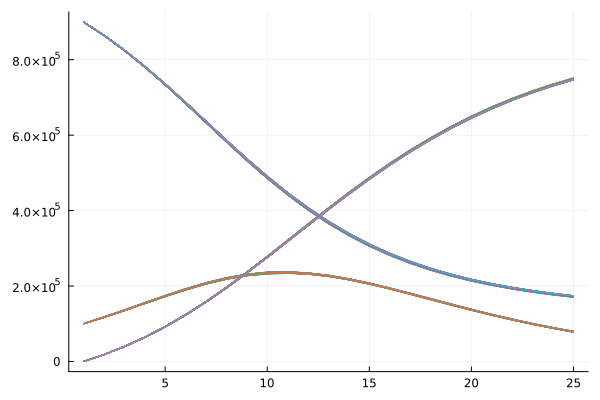

In [106]:
q  = 0.975

p1 = plot_quantile(Array(1:1:T), x[:, 1,:], 0.05)
p2 = plot_quantile(Array(1:1:T), x[:, 2,:], 0.05)
p3 = plot_quantile(Array(1:1:T), x[:, 3,:], 0.05)

pcases = plot_quantile(Array(1:1:T), ysim, 0.05)


pp1 = plot(Array(1:1:T), x[:,1,:])

plot(p1, p2, p3, pcases, layout = (5, 1))

plot(1:1T, x[:, 1,:], legend=false)
plot!(1:1T, x[:, 2,:], legend=false)
plot!(1:1T, x[:, 3,:], legend=false)


In [122]:
help cov

ErrorException: syntax: extra token "cov" after end of expression

In [123]:
rand_time = rand(1:T)
yi = ysim[rand_time, :]
xi = x[rand_time, 1, :]
dx = cov(xi, yi, dims=2);


MethodError: MethodError: no method matching cov(::Vector{Float64}, ::Vector{Float64}; dims::Int64)

Closest candidates are:
  cov(::AbstractVector, ::AbstractVector; corrected) got unsupported keyword argument "dims"
   @ Statistics /Applications/Julia-1.9.app/Contents/Resources/julia/share/julia/stdlib/v1.9/Statistics/src/Statistics.jl:595
  cov(::AbstractVecOrMat, ::AbstractVecOrMat; dims, corrected)
   @ Statistics /Applications/Julia-1.9.app/Contents/Resources/julia/share/julia/stdlib/v1.9/Statistics/src/Statistics.jl:605
  cov(::AbstractVector; corrected) got unsupported keyword argument "dims"
   @ Statistics /Applications/Julia-1.9.app/Contents/Resources/julia/share/julia/stdlib/v1.9/Statistics/src/Statistics.jl:575
  ...


In [125]:
cov(xi, yi), size(xi), size(yi)

(-5792.297580216637, (700,), (700,))

In [133]:

function eakf(x, y, g, hs)
    """ Ensemble Adjustment Kalman Filter
    """
    n, m = size(x) # x \in R^{n\times m}. n: state space size, m: number of particles

    z    = g(x)   # simulated observations.
    oev  = hs(y)  # measurement error.

    mu   = mean(y, dims=2); # \mu = E[y]
    s2   = var(y, dims=2);  # \var = Var[y]

    sp2  = s2 * oev / (s2 + oev)   # \sigma^2_{\hat{y}} =
    mup  = sp2 * (mu/s2 + z/oev)
    gain = (oev / (oev + s2)) ** (0.5)

    dy = (mup-y) + gain * (y-mu) # gain
    dr = cov(x[rand_time, :, :], yi, dims=2) / s2

    dx = dot(dy, dr)

    return x + dx

end

function δθ(θ, σθ)
    return θ + σθ .* randn(size(θ))
end

function if2(f, g, h, f0, θo, gθ, δθ, Nif, filter)
    """ Iterated filtering with perturbed Bayes map
    """

    x0 = f0(θo)
    for nif in 1:1:Nif

        if nif == 1
            θ_hat = θo()
        else
            θ_hat = gθ(θ_hat)
        end

        for t in 1:δt:T

            x[t+1,:,:] = f(x[t,:,:], θ, t, δt)
            ysim       = g(x[t+1,:,:], θ, t, δt)

            if t in t_infer

                x  = filter(x, y, f, g) # posterior state space.
                θ  = filter(θ, y, f, g) # posterior parameter space.

                θ   = δθ(θ)
            end
        end
    end
    return θ_hat
end



ErrorException: syntax: use "x^y" instead of "x**y" for exponentiation, and "x..." instead of "**x" for splatting.